# N-Body Project 
## Anshak Mallik <br> Computational Astrophysics HS23

Libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import time
import h5py

## Task 1

### 1.1 Step 1
- Preliminarly, **verify the form of the density function $\rho(r)$** by inferring it from the particle distrbution and **compare it with the analytical denstiy function described in the original paper by Hernquist** (from 1990 on Astrophysical Journal available on the web). **Use Poissonian error bars** when comparing the numerical density profile with the analytical expected values.

- Note that the initial conditions are given in a system of units in which $G=1$. **Assume reasonable units of length and mass** for your calculations (nuits of veloctiy and time follow automatically from the assumption) and **discuss your choice**.

#### Units for $G=1$

We are dealing with a globular cluster with the system of units in which the gravitational constant is $G=1$. Thus, it is important to pick the right set of base units. We essentially need to choose a set of new dimensionless units, such that $G=1$ in the new set of units. Let's assume we have the quantity $x$ which has a scale factor $X_0$. This can be converted into an equivalent dimensionless quantity $x' = x/X_0$.

We need to find the appropriate units for the following scale factors: $M_0$ (mass), $R_0$ (length), $T_0$ (time) and $V_0$ (velocity). We will also consider $A_0$ for acceleration.

For a globular cluster, the appropriate scaling factors for the mass and length are: <br>
$M_0 = 1M_{\odot} = 1.989 \cdot 10^{30} \text{kg}$ <br>
$R_0 = 1\text{pc} = 3.086 \cdot 10^{16} \text{m}$

Now, let's assume that the following variable denote the corresponding quantities: $m$ (mass), $r$ (length), $t$ (time), $v$ (velocity) and $a$ (acceleration).

Starting with the gravitational acceleration we get: <br>
$a = G\frac{m}{r^2} \implies a'A_0 = G \cdot m'M_0 \cdot \frac{1}{(r'R_0)^2} \implies a' \frac{R_0}{T_0^2} = G \cdot m'M_0 \cdot \frac{1}{r'^2 R_0^2} \implies a' = G' \frac{m'}{r'^2}$ <br>
Here $a'$, $m'$ and $r'$ are all dimensionless quantities. This means, that $G' = \frac{G M_0 T_0^2}{R_0^3}$ must also be dimensionless. Without loss of generality, let's assume $G'=1$.

From this we we can get the following equation for the scale length of time: <br>
$T_0 = \sqrt{ \frac{R_0^3}{GM_0} } = \sqrt{ \frac{1\text{pc}}{G \cdot 1M_{\odot}}} = 4.705 \cdot 10^{14} \text{s} = 14.92 \text{Myr}$

Similarly, we know that appropriate units for the velocity would be $\text{km/s}$. We get the following for the scale factor: <br>
$V_0 = \frac{R_0}{T_0} = \frac{1\text{pc}}{14.92\text{Myr}} = 0.065 \text{km/s}$.




#### Importing data

In [2]:
filepath = r'data.txt'
column_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'softening', 'potential']
data = pd.read_csv(filepath, delimiter='\t', names=column_names)

Calculating and storing the distance from the center and velocity of each star in 2 new columns: <br>
$r = \sqrt{x^2 + y^2 + z^2}$ and $v = \sqrt{v_x^2 + v_y^2 + v_z^2}$

In [3]:
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
data['velocity'] = np.sqrt(data['vx']**2 + data['vy']**2 + data['vz']**2)

Plotting the data to look at the what the star cluster looks like.

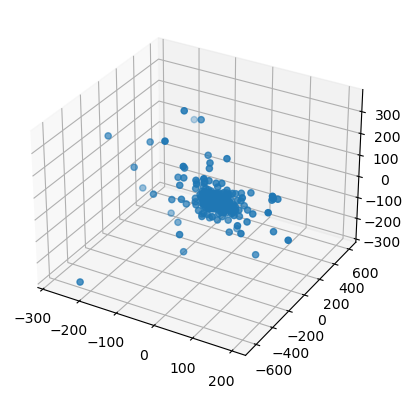

In [4]:
x = data['x'].to_numpy()
y = data['y'].to_numpy()
z = data['z'].to_numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)

#### Fitting Hernquist profile

**TODO**: _Mention what kind of distribution we expect and why we need to a logarithmic bininng. Also state what an ideal binning number would be and why._

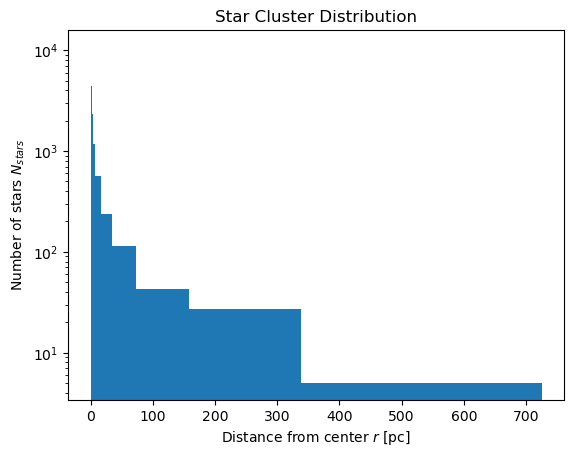

In [68]:
log_min = np.log10(min(data['distance']))
log_max = np.log10(max(data['distance']))
N_bins = 20

bins = np.logspace(log_min, log_max, num=N_bins)
# bins

plt.figure()
plt.title('Star Cluster Distribution')
plt.xlabel(r'Distance from center $r$ [pc]')
plt.ylabel(r'Number of stars $N_{{stars}}$')
hist_data = plt.hist(data['distance'], bins=bins, log=True)

In [16]:
hist_data[0]

array([6.0000e+00, 1.3000e+01, 8.0000e+01, 3.1300e+02, 1.1820e+03,
       3.2940e+03, 7.1770e+03, 1.0803e+04, 1.0579e+04, 7.6090e+03,
       4.4520e+03, 2.3260e+03, 1.1860e+03, 5.6200e+02, 2.3800e+02,
       1.1500e+02, 4.3000e+01, 2.7000e+01, 5.0000e+00])

**TODO**: _What do we get from this distribution? Mention how we can use the count per bin and binning edges for fitting_

In [147]:
N_stars = hist_data[0]
np.sum(N_stars) == data.shape[0]
np.sum(N_stars)

50010.0

In [79]:
bin_edges = hist_data[1]
r_left = bin_edges[:-1]
r_right = bin_edges[1:]

In [19]:
len(r_right) == len(N_stars)

True

Using mean binning values $r_{\text{avg}}$ as edeges of shells to get shell volumes? NO, using the mean binning values is not a good idea. Instead use outer radius $r_{\text{out}}$.

**TODO**: _Include plot of number of stars dependent on radius?_

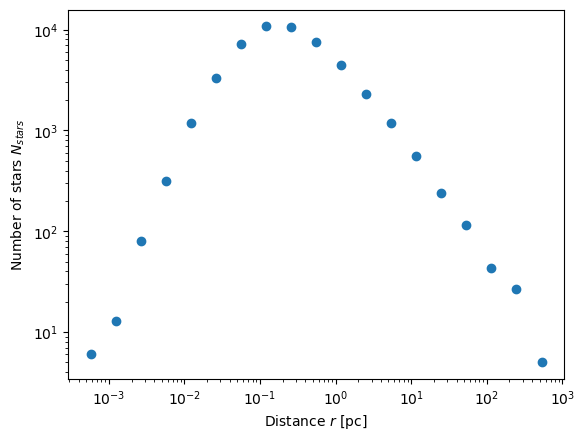

In [20]:
plt.figure()
plt.xlabel(r'Distance $r$ [pc]')
plt.ylabel(r'Number of stars $N_{stars}$')
plt.loglog(bin_centers, N_stars, 'o')

**TODO**: _Fix description of which formula I used!_ The mass within the volume can be caluclated using the number of stars $N_{\text{stars}}$ within the volume that is created by that outer radius.

Next, we need to get the shell volumes using the outer radii: <br>
$V_{\text{shell}} = \frac{4\pi}{3} \Delta r^3$ <br>
Here, $\Delta r = r_{i+1} - r_{i}$ is the difference between 2 consecutive $r_{\text{out}}$.

In [70]:
np.logspace?

In [21]:
# V_shells = []
# for i in range(len(r_outer)-1):
    
#     r_in = r_outer[i]
#     r_out = r_outer[i+1]
    
#     V_shell = 4*np.pi/3 * (r_out**3 - r_in**3)
#     V_shells.append(V_shell)
    
# V_shells = np.array(V_shells)
# V_shells

In [35]:
# V_shells = (4/3) * np.pi * bin_centers**3
# V_shells

In [36]:
V_shells = (4/3) * np.pi * (r_right**3 - r_left**3)
# V_shells = (4/3) * np.pi * bin_centers**3
V_shells

array([1.81556948e-09, 1.79183551e-08, 1.76841181e-07, 1.74529431e-06,
       1.72247901e-05, 1.69996197e-04, 1.67773928e-03, 1.65580709e-02,
       1.63416162e-01, 1.61279910e+00, 1.59171584e+01, 1.57090820e+02,
       1.55037256e+03, 1.53010537e+04, 1.51010312e+05, 1.49036235e+06,
       1.47087965e+07, 1.45165163e+08, 1.43267496e+09])

Finally, we can get the density of each shell:

$\rho = \frac{m_{\text{shell}}}{V_{\text{shell}}} = \frac{N_{\text{stars}}m_{\text{star}}}{V_{\text{shell}}}$

**TODO**: _Complete sentence_ $\rightarrow$ We know the number of stars $N_{\text{stars}}$ for each me

**TODO**: _Explain how we get total mass and observed densities_

In [39]:
star_mass = data['mass'].values[0]
rho_obs = N_stars*star_mass / V_shells

len(N_stars)
len(V_shells)
total_mass = np.sum(data['mass'].to_numpy())
print('The total mass of all stars is M = {:.2e} M_Sol!'.format(total_mass))

The total mass of all stars is M = 4.62e+06 M_Sol!


In [25]:
len(rho_obs[1:-1])

17

In [26]:
def log_Hernquist_profile(r, a):
    log_rho = np.log10(total_mass/(2*np.pi)) + np.log10(a) - np.log10(r) - 3*np.log10(r+a)
    return log_rho

# for i in range(len(a0)):
    
#     popt, pcov = curve_fit(log_Hernquist_profile, r_outer[1:], (rho_obs), maxfev=1500)
#     a_fit = popt[0]
#     a_fit_dev = np.sqrt(pcov[0,0])
    
#     print('a0 = {:.2f} -> a = {:.3f} +/- {:.3f} -> relative error: {:.3f}'.format(a0[i], a_fit, a_fit_dev, a_fit_dev/a_fit))

**TODO**: _Mention Hernquist profile and how we will fit it. Don't think we need the logarithmically simplified version_

In [27]:
#Function that defines the Hernquist density profile
def Hernquist_profile(r, a):
    rho = total_mass/(2*np.pi) * (a/r) * (1/(r+a)**3)
    return rho

**TODO**: _Sanity check to see if this value for half-mass radius is correct. Reorder stars in order of increasing distance. Since all stars have the same mass, we can simply assume that the half-mass radius will be around the star which lies in the middle of the newly ordered dataset._

In [ ]:
#TODO: check how many stars/mass within half-mass radius
# np.sort(data['distance'])
sort_dist_ind = np.argsort(data['distance'])

sort_dist = data['distance'][sort_dist_ind].to_numpy()
# sort_dist == np.sort(data['distance'])

r_hm = sort_dist[int(len(data['distance'])/2)]
print('The half-mass radius of the star cluster according to the data lies at r_hm = {:.4f} pc'.format(r_hm))

$r_{\text{hm}} = \big( 1+\sqrt{2} \big) a$

In [28]:
a = r_hm/(1+np.sqrt(2))
print('The scale length of the star cluster according to the data is a = {:.4f}'.format(a))

The half-mass radius of the star cluster according to the data lies at r_hm = 0.1887 pc
The scale length of the star cluster according to the data is a = 0.0782


**Bin centers**

**TODO**: _Explain this section._
- Binning such that $\Delta \rho / \rho \propto \Delta n / n$ is not too big or small.
- Poissonian error $\Delta n \sim 

In [138]:
# len((r_left + r_right)/2)

# bin_centers = np.zeros(N_bins+1)

# bin_centers[0] = min(data['distance'])
# bin_centers[1:-1] = (r_left + r_right)/2
# bin_centers[-1] = max(data['distance'])
# # len(bin_centers[1:])
# bin_centers

# star_mass = data['mass'].values[0]

# V_shells_centers = (4/3) * np.pi * bin_centers**3
# V_shells_centers

# len(V_shells_centers)

# N_stars_centers = np.zeros_like(bin_centers)
# N_stars_centers
# for i in range(N_bins):
#     N_stars_centers[i+1] = len( data[(data['distance'] >= bin_centers[i]) & (data['distance'] <= bin_centers[i+1])] )
    
# if np.sum(N_stars_centers) == data.shape[0]:
#     print(len(N_stars_centers))

# rho_obs_centers = N_stars_centers * star_mass / V_shells_centers
# len(rho_obs_centers)

# # a0 = np.linspace(0, 1, 101)
# # for i in range(len(a0)):

# #     popt, pcov = curve_fit(Hernquist_profile, bin_centers, rho_obs, p0=(a0[i]))
# #     a_fit = popt[0]
# #     a_fit_dev = np.sqrt(pcov[0,0])
    
# #     print('a0 = {:.2f} -> a = {:.3f} +/- {:.3f} -> relative error: {:.3f}'.format(a0[i], a_fit, a_fit_dev, a_fit_dev/a_fit))
    
# popt, pcov = curve_fit(Hernquist_profile, bin_centers, rho_obs_centers, p0=(0.06)) #add errors for rho
# a_fit = popt[0]
# a_fit_dev = np.sqrt(pcov[0,0])
# print('Using on the bin centers: a_fit = {:.3f} +/- {:.3f}'.format(a_fit, a_fit_dev))

In [136]:
# fig, ax = plt.subplots(1, 2, figsize=(15,5))

# ax[0].set_title(r'Radial density profile (logarithmic values)')
# ax[0].set_xlabel(r'$r$ [pc]')
# ax[0].set_ylabel(r'$\ln{(\rho(r))}$ [$M_{\odot}$/pc$^3$]')
# ax[0].plot(bin_centers, log_Hernquist_profile(bin_centers, a_fit), color='red', lw=3, label=r'Hernquist $\ln{{(\rho_H)}}$ ($a = $ {:.3f})'.format(a_fit), zorder=0)
# ax[0].errorbar(bin_centers, np.log10(rho_obs_centers), yerr=np.log10((1/np.sqrt(N_stars))), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\ln{(\rho_{obs})}$', zorder=1)
# ax[0].legend()

# ax[1].set_title(r'Radial density profile (logarithmic scale)')
# ax[1].set_xlabel(r'$r$ [pc]')
# ax[1].set_ylabel(r'${\rho(r)}$ [$M_{\odot}$/pc$^3$]')

# ax[1].set_xscale('log')
# ax[1].set_yscale('log')

# ax[1].plot(bin_centers, Hernquist_profile(bin_centers, a_fit), color='red', lw=3, label=r'Hernquist $\rho_H$ ($a = ${:.3f})'.format(a_fit), zorder=0)
# ax[1].errorbar(bin_centers, rho_obs_centers, yerr=1/np.sqrt(N_stars), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\rho_{obs}$', zorder=1)
# ax[1].legend()

In [137]:
# r_hm_fit = (1+np.sqrt(2))*a_fit
# print('The half-mass radius of the star cluster according to the fit for bin:centers lies at r_hm_fit = {:.4f} pc'.format(r_hm_fit))

In [153]:
(N_stars)

array([6.0000e+00, 1.3000e+01, 8.0000e+01, 3.1300e+02, 1.1820e+03,
       3.2940e+03, 7.1770e+03, 1.0803e+04, 1.0579e+04, 7.6090e+03,
       4.4520e+03, 2.3260e+03, 1.1860e+03, 5.6200e+02, 2.3800e+02,
       1.1500e+02, 4.3000e+01, 2.7000e+01, 5.0000e+00])

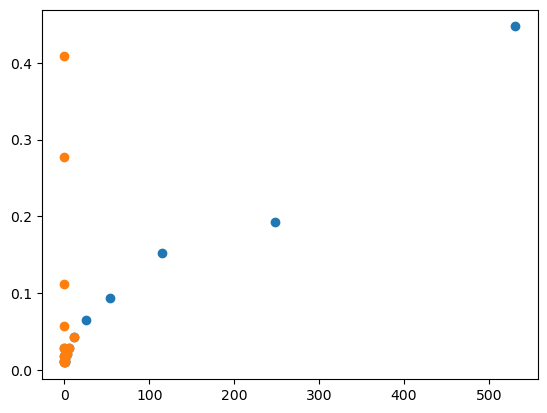

In [275]:
#Poissonian error
k = 4
plt.plot(bin_centers[k:], 1/np.sqrt(N_stars[k:]), 'o')

l = -5
plt.plot(bin_centers[:l], 1/np.sqrt(N_stars[:l]), 'o')

**TODO**: _Explain how we get bin centers and why we use geometric mean._

In [283]:
bin_centers = (r_left * r_right)**0.5
# bin_centers = (r_left + r_right)*0.5
(bin_centers)

array([5.35459037e-04, 1.14856261e-03, 2.46367319e-03, 5.28459268e-03,
       1.13354807e-02, 2.43146691e-02, 5.21551004e-02, 1.11872980e-01,
       2.39968165e-01, 5.14733048e-01, 1.10410525e+00, 2.36831190e+00,
       5.08004219e+00, 1.08967187e+01, 2.33735223e+01, 5.01363353e+01,
       1.07542718e+02, 2.30679728e+02, 4.94809299e+02])

In [158]:
curve_fit?

In [279]:
rho_obs_err = (star_mass/V_shells) * (1/np.sqrt(N_stars))
start, end = 4, -5
# popt, pcov = curve_fit(Hernquist_profile, bin_centers, rho_obs, p0=(0.07)) #add errors for rho
popt, pcov = curve_fit(Hernquist_profile, bin_centers[start:end], rho_obs[start:end], p0=(0.07), sigma=rho_obs_err[start:end])

a_fit = popt[0]
a_fit_dev = np.sqrt(pcov[0,0])
print('Using on the bin centers: a_fit = {:.3f} +/- {:.6f}'.format(a_fit, a_fit_dev))

Using on the bin centers: a_fit = 0.079 +/- 0.011467


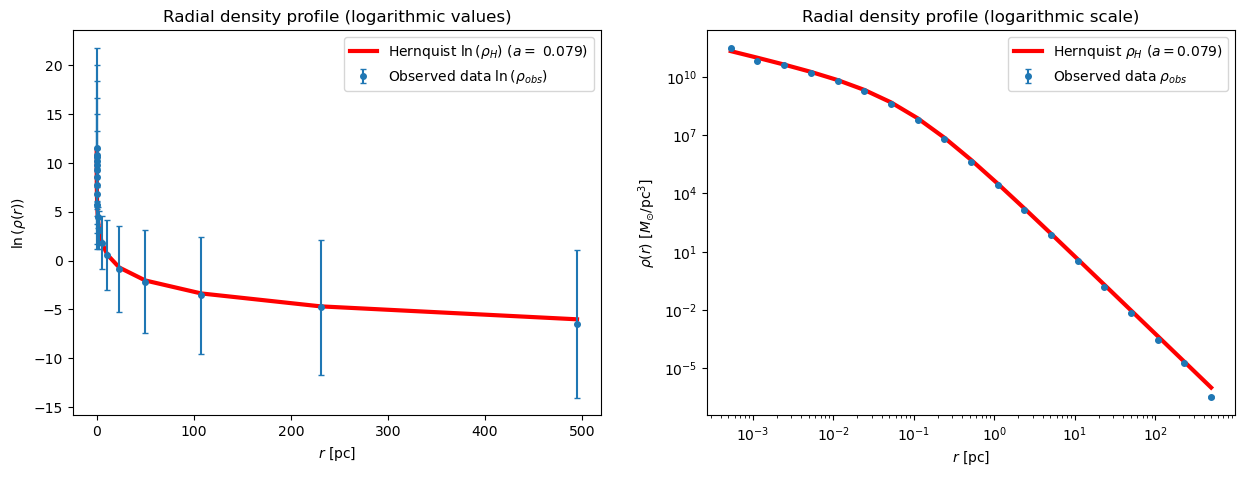

In [280]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].set_title(r'Radial density profile (logarithmic values)')
ax[0].set_xlabel(r'$r$ [pc]')
ax[0].set_ylabel(r'$\ln{(\rho(r))}$')
ax[0].plot(bin_centers, log_Hernquist_profile(bin_centers, a_fit), color='red', lw=3, label=r'Hernquist $\ln{{(\rho_H)}}$ ($a = $ {:.3f})'.format(a_fit), zorder=0)
ax[0].errorbar(bin_centers, np.log10(rho_obs), yerr=np.log10(rho_obs_err), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\ln{(\rho_{obs})}$', zorder=1)
ax[0].legend()

ax[1].set_title(r'Radial density profile (logarithmic scale)')
ax[1].set_xlabel(r'$r$ [pc]')
ax[1].set_ylabel(r'${\rho(r)}$ [$M_{\odot}$/pc$^3$]')

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].plot(bin_centers, Hernquist_profile(bin_centers, a_fit), color='red', lw=3, label=r'Hernquist $\rho_H$ ($a = ${:.3f})'.format(a_fit), zorder=0)
ax[1].errorbar(bin_centers, rho_obs, yerr=(rho_obs_err), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\rho_{obs}$', zorder=1)
ax[1].legend()

In [ ]:
r_hm_fit = (1+np.sqrt(2))*a_fit
r_hm_fit_dev = (1+np.sqrt(2))*a_fit_dev
print('The half-mass radius of the star cluster according to the fit for bin_centers lies at r_hm_fit = {:.4f} +/- {:.4f} pc'.format(r_hm_fit, r_hm_fit_dev))

**Right most bin edges**

In [40]:
# # a0 = np.linspace(0, 1, 101)
# # for i in range(len(a0)):

# #     popt, pcov = curve_fit(Hernquist_profile, r_right, rho_obs, p0=(a0[i]))
# #     a_fit = popt[0]
# #     a_fit_dev = np.sqrt(pcov[0,0])
    
# #     print('a0 = {:.2f} -> a = {:.3f} +/- {:.3f} -> relative error: {:.3f}'.format(a0[i], a_fit, a_fit_dev, a_fit_dev/a_fit))
    
# popt, pcov = curve_fit(Hernquist_profile, r_right, rho_obs, p0=(0.07)) #add errors for rho
# a_fit = popt[0]
# a_fit_dev = np.sqrt(pcov[0,0])
# print('Using on the rightmost bin edges: a_fit = {:.3f} +/- {:.3f}'.format(a_fit, a_fit_dev))

Using on the rightmost bin edges: a_fit = 0.057 +/- 0.001


In [179]:
# fig, ax = plt.subplots(1, 2, figsize=(15,5))

# ax[0].set_title(r'Radial density profile (logarithmic values)')
# ax[0].set_xlabel(r'$r$ [pc]')
# ax[0].set_ylabel(r'$\ln{(\rho(r))}$ [$M_{\odot}$/pc$^3$]')
# ax[0].plot(r_right, log_Hernquist_profile(r_right, a_fit), color='red', lw=3, label=r'Hernquist $\ln{{(\rho_H)}}$ ($a = $ {:.3f})'.format(a_fit), zorder=0)
# ax[0].errorbar(r_right, np.log10(rho_obs), yerr=np.log10((1/np.sqrt(N_stars))), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\ln{(\rho_{obs})}$', zorder=1)
# ax[0].legend()

# ax[1].set_title(r'Radial density profile (logarithmic scale)')
# ax[1].set_xlabel(r'$r$ [pc]')
# ax[1].set_ylabel(r'${\rho(r)}$ [$M_{\odot}$/pc$^3$]')

# ax[1].set_xscale('log')
# ax[1].set_yscale('log')

# ax[1].plot(r_right, Hernquist_profile(r_right, a_fit), color='red', lw=3, label=r'Hernquist $\rho_H$ ($a = ${:.3f})'.format(a_fit), zorder=0)
# ax[1].errorbar(r_right, rho_obs, yerr=(1/np.sqrt(N_stars)), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\rho_{obs}$', zorder=1)
# ax[1].legend()

Using obtained scale length, we can figure out what the half-mass radius should be:

$r_{\text{hm}} = (1 + \sqrt{2})a$

In [180]:
# r_hm_fit = (1+np.sqrt(2))*a_fit
# print('The half-mass radius of the star cluster according to the fit for r_right lies at r_hm_fit = {:.4f} pc'.format(r_hm_fit))

**Left most bin edges**

In [181]:
# # # a0 = np.linspace(0, 10, 101)
# # # for i in range(len(a0)):

# # #     popt, pcov = curve_fit(Hernquist_profile, r_left, rho_obs, p0=(a0[i]))
# # #     a_fit = popt[0]
# # #     a_fit_dev = np.sqrt(pcov[0,0])
    
# # #     print('a0 = {:.2f} -> a = {:.3f} +/- {:.3f} -> relative error: {:.3f}'.format(a0[i], a_fit, a_fit_dev, a_fit_dev/a_fit))
    
# popt, pcov = curve_fit(Hernquist_profile, r_left, rho_obs, p0=(0.07))
# a_fit = popt[0]
# a_fit_dev = np.sqrt(pcov[0,0])
# print('Using on the rightmost bin edges: a_fit = {:.3f} +/- {:.3f}'.format(a_fit, a_fit_dev))

In [182]:
# fig, ax = plt.subplots(1, 2, figsize=(15,5))

# ax[0].set_title(r'Radial density profile (logarithmic values)')
# ax[0].set_xlabel(r'$r$ [pc]')
# ax[0].set_ylabel(r'$\ln{(\rho(r))}$ [$M_{\odot}$/pc$^3$]')
# ax[0].plot(r_left, log_Hernquist_profile(r_left, a_fit), color='red', lw=3, label=r'Hernquist $\ln{{(\rho_H)}}$ ($a = $ {:.3f})'.format(a_fit), zorder=0)
# ax[0].errorbar(r_left, np.log10(rho_obs), yerr=np.log10((1/np.sqrt(N_stars))), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\ln{(\rho_{obs})}$', zorder=1)
# ax[0].legend()

# ax[1].set_title(r'Radial density profile (logarithmic scale)')
# ax[1].set_xlabel(r'$r$ [pc]')
# ax[1].set_ylabel(r'${\rho(r)}$ [$M_{\odot}$/pc$^3$]')

# ax[1].set_xscale('log')
# ax[1].set_yscale('log')

# ax[1].plot(r_left, Hernquist_profile(r_left, a_fit), color='red', lw=3, label=r'Hernquist $\rho_H$ ($a = ${:.3f})'.format(a_fit), zorder=0)
# ax[1].errorbar(r_left, rho_obs, yerr=1/np.sqrt(N_stars), color='C0', fmt='o', markersize=4, capsize=2, label=r'Observed data $\rho_{obs}$', zorder=1)
# ax[1].legend()


Using obtained scale length, we can figure out what the half-mass radius should be:

$r_{\text{hm}} = (1 + \sqrt{2})a$

In [183]:
# r_hm_fit = (1+np.sqrt(2))*a_fit
# print('The half-mass radius of the star cluster according to the fit for r_left lies at r_hm_fit = {:.4f} pc'.format(r_hm_fit))

In [29]:
# fig, ax = plt.subplots(2, 2, figsize=(16,12))

# #[0,0]
# ax[0,0].set_title(r'$\ln{(\rho)}$ with $\ln{(\Delta \rho)}$')
# ax[0,0].set_xlabel(r'$r$ [pc]')
# ax[0,0].set_ylabel(r'$\ln{\rho}$ [$M_{\odot}$/pc$^3$]')

# ax[0,0].plot(r_outer, log_Hernquist_profile(r_outer, a_fit), zorder=0, color='red')
# # ax[0,0].errorbar(r_outer[1:], np.log(rho_obs), yerr=(1/np.sqrt(np.log(N_stars))), fmt='o', capsize=2, zorder=1, markersize=5, color='C0', label=r'$\Delta \rho \sim (\ln{N_S})^{-0.5}$')
# ax[0,0].errorbar(r_outer[1:], np.log(rho_obs), yerr=np.log((1/np.sqrt(N_stars))), fmt='o', capsize=2, zorder=1, markersize=3, color='C4', label=r'$\Delta \rho \sim \ln{(N_S^{-0.5})}$')
# ax[0,0].legend()


# #[0,1]
# ax[0,1].set_title(r'$\ln{(\rho)}$ with ${\Delta \rho}$')
# ax[0,1].set_xlabel(r'$r$ [pc]')
# # ax[0,1].set_ylabel(r'$\ln{\rho}$ [$M_{\odot}$/pc$^3$]')

# ax[0,1].plot(r_outer, log_Hernquist_profile(r_outer, a_fit), zorder=0, color='red')
# ax[0,1].errorbar(r_outer[1:], np.log(rho_obs), yerr=((1/np.sqrt(N_stars))), fmt='o', capsize=2, zorder=1, markersize=5, color='C0', label=r'$\Delta \rho \sim {(N_S^{-1/2})}$')
# ax[0,1].legend()




# #[1,0]
# ax[1,0].set_title(r'$\rho$ with $\ln{(\Delta \rho)}$')
# ax[1,0].set_xlabel(r'$r$ [pc]')
# ax[1,0].set_ylabel(r'${\rho}$ [$M_{\odot}$/pc$^3$]')

# ax[1,0].set_xscale('log')
# ax[1,0].set_yscale('log')

# ax[1,0].plot(r_outer, Hernquist_profile(r_outer, a_fit), zorder=0, color='red')
# # ax[1,0].errorbar(r_outer[1:], (rho_obs), yerr=(1/np.sqrt(np.log(N_stars))), fmt='o', capsize=2, zorder=1, markersize=5, color='C0', label=r'$\Delta \rho \sim (\ln{N_S})^{-0.5}$')
# ax[1,0].errorbar(r_outer[1:], (rho_obs), yerr=np.log((1/np.sqrt(N_stars))), fmt='o', capsize=2, zorder=1, markersize=3, color='C4', label=r'$\Delta \rho \sim \ln{(N_S^{-0.5})}$')
# ax[1,0].legend()


# #[1,1]
# ax[1,1].set_title(r'$\rho$ with $\Delta \rho$')
# ax[1,1].set_xlabel(r'$r$ [pc]')
# # ax[1,1].set_ylabel(r'${\rho}$ [$M_{\odot}$/pc$^3$]')

# ax[1,1].set_xscale('log')
# ax[1,1].set_yscale('log')

# ax[1,1].plot(r_outer, Hernquist_profile(r_outer, a_fit), zorder=0, color='red')
# ax[1,1].errorbar(r_outer[1:], (rho_obs), yerr=((1/np.sqrt(N_stars))), fmt='o', capsize=2, zorder=1, markersize=5, color='C0', label=r'$\Delta \rho \sim {(N_S^{-1/2})}$')
# ax[1,1].legend()

**TODO**: _Explain how good fit is also by using chi squared_

In [30]:
np.log(rho_obs)

array([ 26.61624622,  24.72307041,  24.52894467,  23.60084976,
        22.60854021,  21.31357914,  19.75118966,  17.7922311 ,
        15.38207844,  12.65107065,   9.71260187,   6.67524216,
         3.62780033,   0.43394391,  -2.75469384,  -6.01006646,
        -9.09049063, -12.33402879, -16.83727439])

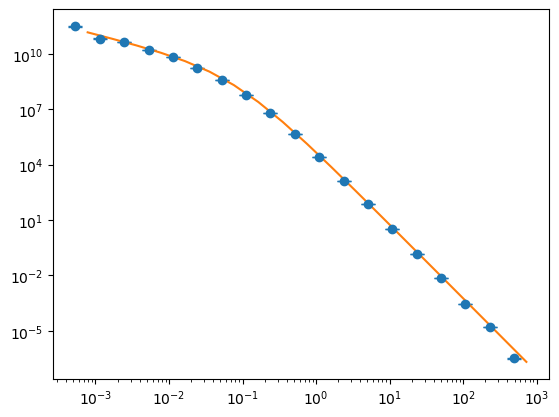

In [285]:
fig = plt.figure()
ax = plt.axes()
ax.set_yscale('log')
ax.set_xscale('log')
ax.errorbar(bin_centers, rho_obs, yerr=rho_obs_err, fmt='o', capsize=5)
ax.plot(r_right, Hernquist_profile(r_right, a_fit))

### 1.2 Step 2

- Compute the direct N-Body forces between particles (note that the array potential[i] is not needed for this purpose). **Start by assuming a softening of the order of the mean interparticle separation in the system**, then repeat the force calculation by experiment with different values of the softening and discuss your results.

#### Mean Inter-Particle Separation $d$ and Softening $\varepsilon$
Before beginning with the direct force calculation, we need to figure out what we need to use for softening $\varepsilon$. We can assume it to be of the same order of magnitude as the mean inter-particle separation, which is given by:

$d = \bigg( \frac{(4\pi/3)R^3}{N} \bigg) ^{\frac{1}{3}}$

**TODO**; _Justify why we use r_hm_ (Full cluster would be too big and interparticle separation would not accurately represent what we want it to. Also, $r_{\text{hm}}$ is a characteristic length of a clu. <br>
Thus, to determine this we need the number of stars $N$ inside a specific radius $R$. We could use the expected half-mass radius $r_{\text{hm}}$ and the number stars inside the sphere it creates. This is simply half of the total numbers of stars, as all stars have the same mass. So, $N = N_{tot}/2$.

In [185]:
#Total number of stars present
N_stars_tot = int(np.sum(N_stars))
N_stars_tot

50010

In [186]:
r_hm
r_max = np.max(data['distance'].values)
r_max

724.689657812915

In [189]:
#r_hm and all stars
d1 = ((4*np.pi/3)*r_hm**3/N_stars_tot)**(1/3)
d1

0.008258388559901865

In [190]:
#Using the half-mass radius and the number of stars present within it
d = ((4*np.pi/3)*r_hm**3/(N_stars_tot/2))**(1/3)
print('The mean inter-particle separation is \nd = {:.2e}'.format(d))

The mean inter-particle separation is 
d = 1.04e-02


We see that $d$ has an order of magnitude of $10^{-2}$. We can assume the softening is also $\varepsilon \sim 10^{-2}$. For now, let's assume $\varepsilon_{\text{init}} = 1\cdot 10^{-2}$.

In [191]:
#Initialising softening parameter
eps_init = 1e-2
eps_init

0.01

- To check the direct force calculation result and its dependence on the softening choice, **compare it with the analytical force expected based on the application of Newton's second theorem for spherical potentials and plot the result** (use the book "Galactic Dynamics" by Binney and Tremaine as a main reference for the theoretical notions, in particular sec. 2.2 (most recent version of the book) or 2.1 (1987 version)).

#### Direct Force Calculation
We will use the direct summation method to compute the forces. The equation of motion for this also depends on the softening:

$\mathbf{\ddot{r_i}} = -G \sum_{j=1}^N \frac{m_j}{[\mathbf{r_i}-\mathbf{r_j} + \varepsilon^2]^{3/2}} (\mathbf{r_i}-\mathbf{r_j})$

The gravitation softening parameter $\varepsilon$ is introduced for computational efficiency and to enforce numerical smoothness of the model for collisionless fluids. <br>
In the case of a collisionless fluid, we need to avoid the correlation between 2 stars in the cluster. This happens when their own velocities dominate over the forces of gravity. In other words, the square of the mean velocity of the stars $\langle v^2 \rangle$ should be much greater than the circular velocity of an orbit with radius $\varepsilon$:

$\langle v^2 \rangle \propto \frac{GM}{R} \gg \frac{GM}{\varepsilon}$

By picking an ideal softening $\varepsilon$, the relaxation time $t_{\text{relax}}$ can be controlled which in turn can lead to building a collisionless system. We can quickly check if the order of magnitude obtained for $\varepsilon$ is correct, by checking the above mentioned condition:

In [192]:
data

,mass,x,y,z,vx,vy,vz,softening,potential,distance,velocity
0,92.4259,-0.003816,-0.079670,-0.019072,3779.6200,354.734,-73.45010,0.1,0.013022,0.082010,3796.940673
1,92.4259,-0.032298,-0.249461,-0.010890,3250.5900,-674.280,-18.33470,0.1,0.013022,0.251779,3319.838103
2,92.4259,0.067577,-0.810356,-0.006849,2190.8600,199.053,3.86061,0.1,0.013022,0.813198,2199.887393
3,92.4259,-0.152755,0.276704,-0.002704,-2695.1400,-1345.020,105.94600,0.1,0.013022,0.316080,3013.981250
4,92.4259,-0.216623,0.150557,-0.002755,-1811.8900,-2595.570,85.85910,0.1,0.013022,0.263819,3166.591351
...,...,...,...,...,...,...,...,...,...,...,...
50005,92.4259,-0.034591,-0.004853,0.038082,2274.8300,4239.630,-225.45900,0.1,0.013022,0.051675,4816.652969
50006,92.4259,0.100105,-0.006709,-0.025669,-751.0680,-1963.650,113.92200,0.1,0.013022,0.103561,2105.469707
50007,92.4259,0.045565,-0.075928,0.023182,-782.9830,581.401,608.46500,0.1,0.013022,0.091535,1149.486475
50008,92.4259,0.273587,0.567563,0.255294,-20.4115,-212.075,-715.19100,0.1,0.013022,0.679818,746.251031


In [71]:
#Velocity parameter system where G=1
V0 = 0.065 #[km/s]

#Square mean velocity from data
v_squared_mean_data = np.mean(data['velocity'].values**2)
#CORRECT
print('The squared mean velcotiy of stars according to the data is \nv_mean^2 = {:.2e} = {:.2e} km/s'.format(v_squared_mean_data, (V0**2 * v_squared_mean_data)))
print('The squared mean velcotiy of stars according to the data is \nv_mean^2 = {:.2e}'.format(v_squared_mean_data))
# print('The mean velcotiy of stars according to the data is \nv_mean = {:.2e}'.format(np.sqrt(v_squared_mean_data)))


The squared mean velcotiy of stars according to the data is 
v_mean^2 = 9.54e+06 = 4.03e+04 km/s
The squared mean velcotiy of stars according to the data is 
v_mean^2 = 9.54e+06


Above method seems wrong, probably something with units <br>
**Question**: Why does this not work? Look at it again!

**TODO**: _Explain why I can use velocity of half-mass system instead of directly from data._

**TODO**: _Figure out why it isn't working._

In [38]:
#Squared circular velocity in half-mass radius
m_hm = total_mass/2
v_hm = np.sqrt(m_hm/r_hm)
print('The squared of the mean velocity of stars in the half-mass system is \nv_hm^2 = {:.2e}'.format(v_hm**2))

The squared of the mean velocity of stars in the half-mass system is 
v_hm^2 = 1.22e+07


In [39]:
#Squared circular velocity around an orbit with radius ε
v_circ_squared = total_mass/eps_init #G=1
print('The square of the mean velcotiy of stars according to the data is \nv_circ^2 = {:.2e}'.format(v_circ_squared))

# (v_squared_mean_data/v_circ_squared)**(-1)

The square of the mean velcotiy of stars according to the data is 
v_circ^2 = 4.62e+08


In [40]:
# #Velocity parameter system where G=1
# V0 = 0.065 #[km/s]

# #Mean velocity from data
# v_mean_data = np.mean(data['velocity'].values)
# print('The mean velcotiy of stars according to the data is \nv_mean = {:.2e}'.format(v_mean_data))

In [41]:
star_mass = data['mass'].values[0]
np.sqrt(star_mass/eps_init)

96.1383898346545

**Normal computing**

In [42]:
# def calculate_force(mj, r1, r2, eps):
    
#     x1, y1, z1 = r1
#     x2, y2, z2 = r2
    
#     r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
    
#     F12 = (mj/(r12**2 + eps**2)**(3/2)) * (r2-r1)
    
#     return F12


# def calculate_forces(dataset, eps):
    
#     forces = np.zeros((len(dataset), 3))
    
#     for i in range(len(dataset)):
#         for j in range(len(dataset)):
            
#             mj = dataset['mass'][j]
#             ri = np.array([dataset['x'][i], dataset['y'][i], dataset['z'][i]])
#             rj = np.array([dataset['x'][j], dataset['y'][j], dataset['z'][j]])

#             if i != j:                
#                 Fij = calculate_force(mj, ri, rj, eps)  
#                 forces[i] += Fij
                
#     return forces

**Parallel processing** <br>
**TODO**: _Read up on it to be able to explain what this is._

**TODO**: _Compute forces for 50k stars using parallel computing and explain it._ <br> 
**QUESTION**: Ask Aadi if I can borrow his data if I don't manage to make it.

In [225]:
def calculate_force(mj, r1, r2, eps):
    
    x1, y1, z1 = r1
    x2, y2, z2 = r2
    
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
    
    F12 = (mj*star_mass/(r12**2 + eps**2)**(3/2)) * (r2-r1)
    
    return F12

In [44]:
# def calculate_force_parallel_process(dataset, i):
    
#     if i % 1000 == 0:
#         print(i)
        
#     forces = np.zeros(3)
    
#     for j in range(len(data)):
        
#         mj = dataset['mass'][j]
#         ri = np.array([dataset['x'][i], dataset['y'][i], dataset['z'][i]])
#         rj = np.array([dataset['x'][j], dataset['y'][j], dataset['z'][j]])

#         if i != j:            
#             forces += calculate_force(mj, ri, rj, eps)
#         else:
#             forces += np.zeros(3)
            
#     return forces

In [45]:
# from concurrent.futures import ThreadPoolExecutor
# from concurrent.futures import ProcessPoolExecutor

In [46]:
# def calculate_total_forces_parallel_process(dataset, eps, num_workers=30):
    
#     with ProcessPoolExecutor(max_workers = num_workers) as executor:
#         nr_stars = range(len(dataset))
#         results = executor.map(calculate_force_parallel_process, nr_stars)
        
#     forces = np.array(list(results))
    
#     return forces

Using the multiprocessing method here

In [47]:
# ##the multiprocessing one
# Started at 14:52

# 3Record start time for processes
# start_time = time.time()
# forces_parallel_proc = calculate_total_force_parallel_process(stars, epsilon)
# #Record end time
# end_time = time.time()
# #Calculate and print the elapsed time
# elapsed_time = end_time - start_time

# #Data to be saved
# forces_and_time = {'elapsed_time': elapsed_time, "forces" : forces_parallel_proc}

# #Save data to a pickle file
# with open('./created_data/forcerrs_50k.pkl', 'wb') as file:
#    pickle.dump(forces_and_time, file)


# print(f"Elapsed time for multiple processes: {elapsed_time} seconds")

Realised I need to access Euler somehow
- Priority for this not that high at the moment, will come back to fix if needed

In [193]:
# #Check how many cores are available from euler
# import os
# import multiprocessing

# # Get the number of CPU cores
# num_cores = os.cpu_count()

# # Alternatively, you can use multiprocessing module to get the number of available CPU cores
# num_cores_mp = multiprocessing.cpu_count()

# print(f"Number of CPU cores (os.cpu_count()): {num_cores}")
# print(f"Number of CPU cores (multiprocessing.cpu_count()): {num_cores_mp}")
# # print(f"Number of CPU cores available (len(os.sched_getaffinity(0))): {len(os.sched_getaffinity(0))} ")

In [49]:
# #Calculate forces and note how long it takes
# start = time.time()

# subset = 1000
# forces_parallel_process = calculate_total_forces_parallel_processing(data[:subset], eps_init)

# end = time.time()
# elapsed_time = end-start


# #Save the data
# with h5py.File('./subset_forces.h5', 'w') as hf:
#     hf.create_dataset('subset_forces', data=forces_parallel_process)

# print('Elapsed time for parallel processing for {:.0f} stars: {:.3f} s'.format(subset, elapsed_time))

In [50]:
# subset = data.shape[0]

# start = time.time()
# forces = calculate_forces(sort_dist_data[:subset], eps_init)
# # forces
# end = time.time()
# print('Direct force calculation for {:.0f} stars takes {:.3f} s'.format(subset, end-start))

# with h5py.File('./subset_forces.h5', 'w') as hf:
#     hf.create_dataset('subset_forces', data=forces)

**TODO**: _Explain that I'm using the data only within $r_{\text{hm}}$._

In [51]:
# with h5py.File('subset_forces.h5', 'r') as hf:
#     load_array = hf['subset_forces'][:]
# # load_array

In [52]:
data.shape

(50010, 11)

#### Direct Force Calculation and its Dependance on Softening

We can check the result of the direct force calculation and its dependence on the softening parameter by comparing it to the expected solution we get from an analytical approach. This is based on Newton's second theorem for spherical potentials. According to Newton's second theorem, "the gravitational force on a body that lies outside a spherical shell of matter is the same as it would be if all the shell's matter were concentrated into a point center" (Binney & Tremaine, 2007). <br>
Thus, we can compute the force on a star at the edge of a shell using:

$\mathbf{F}(\mathbf{r}) = \frac{GM(r)}{r^2}\mathbf{r}$ 

Here, $M(r)$ is the mass enclosed within a sphere of radius $r$. Let's define a function to calculate the force on a star at the edge of a shell.

In [226]:
def calculate_point_force(i, dataset, eps, indices):
    
    forces = np.zeros(3)
    
    for j in indices:
        
        mj = dataset['mass'][j]
        ri = np.array([dataset['x'][i], dataset['y'][i], dataset['z'][i]])
        rj = np.array([dataset['x'][j], dataset['y'][j], dataset['z'][j]])
        
        if i != j:
            
            forces += calculate_force(mj, ri, rj, eps)
            
    return forces

$M(r) = 4\pi \int_0^{r} \rho(r') r'^2 \mathop{dr'}$ (Binney & Tremaine)

Using this definition for the mass is probably the correct way. Assumes spherical distribution of mass.

In [219]:
def force_binney_tremaine(r, a):
    
    #Calculate enclosed mass using the integral provided by Binney & Tremaine
    m, _ = quad(lambda x: 4*np.pi * Hernquist_profile(x, a) * x**2, 0, r)
    
    #Calculate force at distance r for enclosed mass m
    F = m*star_mass/(r**2)
    
    return F    

$M(r) = M_{\text{tot}} \frac{r^2}{(r+a)^2}$ (Hernquist)

Using this for testing the half-mass radius will obviously give exactly half, since this is what we indirectly used to obtained it.  Assumes spherical distribution of mass.

In [214]:
def force_hernquist(r, a):
    
    #Calculate enclosed mass using the Hernquist profile
    m = total_mass * (r**2)/(r+a)**2
    
    #Calculate force at distance r for enclosed mass m
    F = m*star_mass/(r**2)
    
    return F    

$M(r)$ from data. Raw and does not assume spherical distribution of mass.

In [230]:
def force_data(r):
    
    #Calculate enclosed mass using the data
    N = len(data[data['distance'] <= r])
    m = N * star_mass
    
    #Calculate force at distance r for enclosed mass m
    F = m*star_mass/(r**2)
    
    return F

Playing around with distances to see which ones correspond to how many stars.

In [198]:
distances = np.linspace(0.01, 0.25, 25)
for distance in distances:
    print('{:.2f} pc -> {:.1e} stars'.format(distance, len(data[data['distance'] <= distance])))
    
# sort_dist_data = data[data['distance'] <= 0.01]
# len(sort_dist_data)

0.01 pc -> 6.7e+02 stars
0.02 pc -> 2.1e+03 stars
0.03 pc -> 3.8e+03 stars
0.04 pc -> 5.7e+03 stars
0.05 pc -> 7.5e+03 stars
0.06 pc -> 9.3e+03 stars
0.07 pc -> 1.1e+04 stars
0.08 pc -> 1.3e+04 stars
0.09 pc -> 1.4e+04 stars
0.10 pc -> 1.6e+04 stars
0.11 pc -> 1.7e+04 stars
0.12 pc -> 1.8e+04 stars
0.13 pc -> 1.9e+04 stars
0.14 pc -> 2.1e+04 stars
0.15 pc -> 2.2e+04 stars
0.16 pc -> 2.3e+04 stars
0.17 pc -> 2.3e+04 stars
0.18 pc -> 2.4e+04 stars
0.19 pc -> 2.5e+04 stars
0.20 pc -> 2.6e+04 stars
0.21 pc -> 2.7e+04 stars
0.22 pc -> 2.7e+04 stars
0.23 pc -> 2.8e+04 stars
0.24 pc -> 2.8e+04 stars
0.25 pc -> 2.9e+04 stars


In [306]:
shell_rads = np.array([0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21])
# shell_rads = np.array([0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.24])
# shell_rads = np.array([0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.200, 0.225])
epsilons = np.linspace(0.001, 0.012, 12)

In [307]:
epsilons

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012])

In [308]:
#Create subsets of the data
data_subsets = []
for rad in shell_rads:
    data_subset = data[data['distance'] <= rad]
    data_subsets.append(data_subset)
    
#Number of subsets
N_subsets = len(data_subsets)

In [309]:
# (data_subsets[0].describe())

We are going to compare direct summation vs analytical forces on a subset!! <br>
Steps for getting the force acting on the furthest star in each sub-shell:

**Finding the furthest star and indexing**
- First, find the star furthest away in the sub-shell (idxmax()).
- Save the index of that star (to be able to access it later).
- Save the index of all stars, to be able to iterate over them later.

In [310]:
#Initialise empty lists
indices_list = []
furthest_star_ind_list = []
furthest_star_r_list = []

for i, data_subset in enumerate(data_subsets):
    
    #Defining which subset to work with
    subset = data_subset
    
    #Saving indices of all stars in this subset
    indices = subset.index.to_list()
    indices_list.append(indices)

    #Finding index of furthest star in this subset
    furthest_star_ind = subset['distance'].idxmax()
    furthest_star_ind_list.append(furthest_star_ind)

    #Finding distance of furthest star in this subset
    furthest_star_r = subset.loc[furthest_star_ind]['distance']
    furthest_star_r_list.append(furthest_star_r)
    
#Convert lists into numpy arrays
indices_array = np.array(indices_list, dtype='object')
furthest_star_ind_array = np.array(furthest_star_ind_list)
furthest_star_r_array = np.array(furthest_star_r_list)

In [311]:
furthest_star_ind_list
np.array(furthest_star_r_list)

array([0.02999711, 0.05999164, 0.08999706, 0.11999942, 0.14999463,
       0.1799986 , 0.20999653])

In [312]:
# np.where(subset.index.to_numpy() == 6782) #gives index of star ID of furthest star (555)
# (subset.index.to_list()[555]) #sanity check, this should yield star ID of furthest star (6782)


**Analytical forces**
- Calculate the force on that star in that subset using Binney & Tremaine.
- Save this force on the furthest star (forces_BT).
- Calculate the force on that star in that subset using Hernquist.
- Save this force on the furthest star (forces_H).

**TODO**: _Figure out units here. Will help with fixing units where I had issues earlier with the velocity._

In [313]:
a_fit

0.07902412316295916

In [314]:
#Force calculation using Binney & Tremaine
forces_BT = np.zeros(N_subsets)

for i in range(N_subsets):
    
    force_BT = force_binney_tremaine(furthest_star_r_array[i], a_fit)
    forces_BT[i] = (force_BT)
    
forces_BT

array([3.59436375e+10, 2.21063028e+10, 1.49541569e+10, 1.07853768e+10,
       8.14520738e+09, 6.36749314e+09, 5.11430323e+09])

In [315]:
#Force calculation using Hernquist
forces_H = np.zeros(N_subsets)

for i in range(N_subsets):
    force_H = force_hernquist(furthest_star_r_array[i], a_fit)
    forces_H[i] = force_H
    
forces_H

array([3.59436375e+10, 2.21063028e+10, 1.49541569e+10, 1.07853768e+10,
       8.14520738e+09, 6.36749314e+09, 5.11430323e+09])

In [316]:
#Force calculation using Hernquist
forces_D = np.zeros(N_subsets)

for i in range(N_subsets):
    force_D = force_data(furthest_star_r_array[i])
    forces_D[i] = force_D
    
forces_D

array([3.65406583e+10, 2.21384821e+10, 1.49588701e+10, 1.08544786e+10,
       8.17789138e+09, 6.41913807e+09, 5.13906391e+09])

**Numerical forces**
- Calculate the force on that star in that subset using different softening parameters.
- Save the forces for different parameters but same star in a list.
- Save this list of forces (for different parameters) (forces_num).

In [317]:
N_subsets

7

In [318]:
# %%time
forces_eps_list = []
for i in range(N_subsets):

    
    force_eps_list = []
   
    start = time.time()
    
    for eps in epsilons:
        force_eps_vec = calculate_point_force(furthest_star_ind_array[i], data_subsets[i], eps, indices_array[i])
        force_eps = np.sqrt(force_eps_vec[0]**2 + force_eps_vec[1]**2 + force_eps_vec[2]**2)
        force_eps_list.append(force_eps)
    
    force_eps_array = np.array(force_eps_list)
    
    forces_eps_list.append(force_eps_array)
    
    end = time.time()
    
    print('Subset {:.0f} (r_max = {:.3f} pc): {:.3f} s'.format(i+1, furthest_star_r_array[i], end-start))
    
forces_eps_array = np.array(forces_eps_list, dtype='object')

Subset 1 (r_max = 0.030 pc): 3.762 s
Subset 2 (r_max = 0.060 pc): 9.318 s
Subset 3 (r_max = 0.090 pc): 13.808 s
Subset 4 (r_max = 0.120 pc): 17.955 s
Subset 5 (r_max = 0.150 pc): 23.262 s
Subset 6 (r_max = 0.180 pc): 24.394 s
Subset 7 (r_max = 0.210 pc): 26.120 s


In [107]:
# forces_eps_array[:,0]

In [108]:
forces_eps_array.shape[1] == len(epsilons)

True

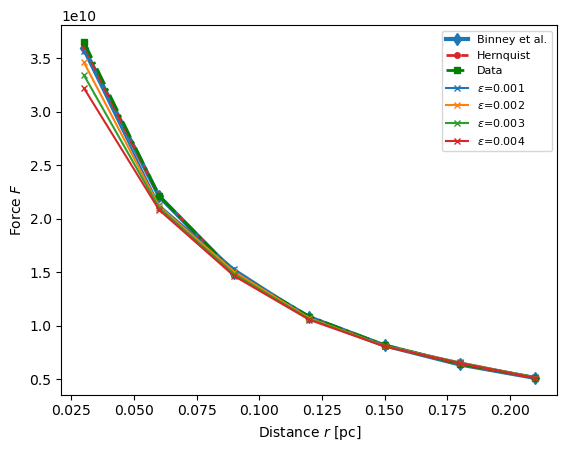

In [355]:
fig = plt.figure()
ax = plt.axes()

ax.set_xlabel(r'Distance $r$ [pc]')
ax.set_ylabel(r'Force $F$')

# ax.set_yscale('log')

# ax.plot(furthest_star_r_array, forces_BT[0]/(furthest_star_r_array)**2/1000)
ax.plot(furthest_star_r_array, forces_BT, 'd-', markersize=6, lw=3, color='C0', label='Binney et al.', zorder=0)
ax.plot(furthest_star_r_array, forces_H, 'o--', markersize=4, lw=2, color='C3', label='Hernquist', zorder=1)
ax.plot(furthest_star_r_array, forces_D, 's-.', markersize=4, lw=2, color='g', label='Data', zorder=2)


# ax.plot(furthest_star_r_array, forces_eps_array[:,3], 'x-', markersize='5', label=r'$\varepsilon$={:.3f}'.format(epsilons[3]), zorder=3+1)
for i in range((forces_eps_array.shape[1])-8):
    ax.plot(furthest_star_r_array, forces_eps_array[:,i], 'x-', markersize='5', label=r'$\varepsilon$={:.3f}'.format(epsilons[i]), zorder=i+1)

ax.legend(fontsize=8)

# plt.plot(furthest_star_r)

**QUESTION**: Best parameter looks like $\varepsilon = 0.004$. However, thats an order of magnitude smaller than expected. Why?

**TODO**
- _Add title_
- _Add units for force_
- _Explain this plot. Is it good? (Yes, goes with $1/r^2$. Or does it? best one seems to be 0.003 or 0.004, use $\chi^2$ to check goodness!). And which epsilon looks the bets and why? (0.004 from looking at it). What do we expect? (Closer to 0 should be closer to theory)._

- **Compute the relaxation timescale of the numerical model given the number of particles and the physical crossing timescale** (use the half-mass radius $r_{\text{hm}}$ and the circular velocity computed at the half-mass radius, $v_c = \sqrt{GM(r_{\text{hm}})/r_{\text{hm}}}$ ). Keeping in mind how the relaxation time formula is derived, **do you expect varying the value of the graviational softening to change the relaxation timescale?** In particular, do you expect it to increase or decrease if the softening is increased above the interparticle separation? Can you explain why?

**Relaxation Timescale**

The relaxation timescale defines the characteristic time it takes for a system to reach an equilibrium state after initially bein perturbed. Mathematically, it is defined as:

$t_{\text{relax}} = \frac{N_{\text{stars}}}{8\ln{(N_{\text{stars}})}} t_{\text{cross}}$

Here, the crossing time $t_{\text{cross}}$ refers to the time it takes for a particle with velocity $v$ to cross a system of size $R$, assuming a striaght trajectory. It is defined as:

$t_{\text{cross}} = R/v$

In our case, we will use the half-mass radius $R = r_{\text{hm}}$ and its associated circular velocity $v = v_c$. 

In [321]:
V0 = 0.065 #km/s

In [322]:
#Circular velocity at r_hm_fit
v_c = np.sqrt((total_mass/2) / r_hm_fit)
print('Circular velocity at r_hm_fit: v_c = {:.0f} = {:.0f} km/s'.format(v_c, V0*v_c))

Circular velocity at r_hm_fit: v_c = 3481 = 226 km/s


**TODO**: _Fix units, get them in either s or yr._ <br>
**QUESTION**: How do we even go about it? Simplify pc and km first and then use $T_0$?

In [323]:
#Crossing time
t_cross = r_hm_fit / v_c
print('Crossing time: t_cross = {:.2e} (pc / km/s)'.format(t_cross))

Crossing time: t_cross = 5.48e-05 (pc / km/s)


In [324]:
#Relaxation time
t_relax = (N_stars_tot) / (8*np.log(N_stars_tot)) * t_cross
print('Relaxation time: t_relax = {:.2e} (pc / km/s)'.format(t_relax))

Relaxation time: t_relax = 3.17e-02 (pc / km/s)


**TODO**: _Think about what timescale this represents! Think Myr using time scale factor $T_0$.

**TODO**: _Do I expect relaxation time $t_{\text{relax}}$ to increase or decrease with $\varepsilon$ is increased above $d$? Why?_

## Task 2: TreeCode

- **Compute the forces on particles (a subset of them would be fine) using multipole expansion (tree-code)**. For multipole calculation decide on a criterion (distance based) to group particles, eventually **experiment with different orders of that expansion**. Finally, **compare the tree-code result with the direct summation result**, in terms of accuracy as well as computational cost. **Try different softenings** for the direct summation **and different opening angles** for the tree-code.

**TODO**: _Explain quickly what TreeCode is and why we want to use it_.
- Lectures from Week 7 and 8 are good for this

Particle located at $\mathbf{r}$ <br>
Group of particles with COM located at $\mathbf{s}$ <br>
Particles of the group are located at $\mathbf{x}_i$ <br>
Aperture of group (what angle spans the group): $\theta \rightarrow$ (small if group is far, big otherwise)

$y = | \mathbf{r} - \mathbf{s}|$ is distance between group and particle <br>
$l = | \langle \mathbf{x}_i - \mathbf{s} \rangle |$ is the average distance between the group's particles and its COM.

$\Phi(\mathbf{r}) = -G \sum_i \frac{m_i}{|\mathbf{r}-\mathbf{x}_i|} = -G \sum_i \frac{m_i}{|\mathbf{r}-\mathbf{s}+\mathbf{s}-\mathbf{x}_i|}$. If opening angle is small enough: $\theta \approx l/y \ll 1$, then $l \ll y$. This means that both $l = | \langle \mathbf{x}_i - \mathbf{s} \rangle |$ and $\theta$ are small enough and we can expand in the denominator:

$\frac{1}{|\mathbf{y}+\mathbf{s}-\mathbf{x}_i|} = \frac{1}{|\mathbf{y}|} - \frac{\mathbf{y} \cdot (\mathbf{s}-\mathbf{x}_i)}{|\mathbf{y}|^3} + \frac{1}{2} \frac{\mathbf{y}^T[ 3(\mathbf{s}-\mathbf{x}_i)(\mathbf{s}-\mathbf{x}_i)^T - (\mathbf{s}-\mathbf{x}_i)^2 ]\mathbf{y}}{|\mathbf{y}|^5}$

The 3 terms are known as monopole, dipole and quadrupole. The dipole term disappears if when the expansion is done in the COM frame. <br>
$M = \sum_i m_i$ <br>
$Q_{ij} = \sum_k m_k [ 3(\mathbf{s}-\mathbf{x}_k)_i (\mathbf{s}-\mathbf{x}_k)_j - \delta_{ij}(\mathbf{s}-\mathbf{x}_k)^2 ]$

$\rightarrow \Phi(\mathbf{r}) = -G \Big( \frac{M}{|\mathbf{y}|} + \frac{1}{2}\frac{\mathbf{y}^T \mathbf{Q} \mathbf{y}}{|\mathbf{y}|^5} \Big)$

- node0/topnode: full domain, contains all stars
- leaf node: no children, only 1 star

**A simple and pythonic Barnes-Hut treecode** <br>
https://mikegrudic.wordpress.com/2017/07/11/a-simple-and-pythonic-barnes-hut-treecode/

#### Hierarchical force summation
The idea of the Barnes-Hut method is to group together neighbouring stars and treat them as one big mass for purposes of calculating their contribuion to $g$, _if_ they are far enough away from the point of interest that this is a good approximation. Consider a scattering of point masses of total mass $M$ localized within a sphere of radius $a$, whose centre of mass $x'$ lies at distance $r$ from the point of interest $x$. The formalism of multipole expansion tells us that we can express the gravitational field as the sum of a monopole part that scales as $1/r^2$, a dipole part that sccales as $a/r^3$, a quadrupole part that goes as $a^2/r^4$, and so on. By lumping the particles together we are just keeping the monopole part, so the relative accuracy of the approximation is determined by the ratio $\theta = a/r$.

Thus, if we want to compute the field at $x$ to a certain guaranteed accuracy, we can use a recursive algorithm:
1. Group together all stars and compute their total mass $M$, their center of mass $x'$, and their spatial extent $a$.
2. If $\theta = a/r$ is less than a certain specified maximum value $\theta_{\text{max}}$, or the group consists of only one star, the approximation of lumping the stars together is good enough, so we add the field contribution due to a mass $M$ at point $x'$ and we're done.
3. Otherwise, if $\theta$ is too big, partition the stars into smaller groups and repeat this procedure and go back to step 1 for each subgroup.

It is straightforward to see that there is some maximum tree depth $\sim \log{N}$ that can be reached before we have subdivided down to a single star, and the recursion terminates. A standard value of $\theta_{\text{max}}$ for $1\%$ for accuracy is $0.7$.

**QUESTIONs**: 
- Why is the condition node.size/r < thetamax? (line 15)
- Where can I see/implement the multipole expansion?

In [325]:
#Recursive function to get leaf nodes?
def TreeWalk(node, node0, thetamax=0.7, G=1.0):
    """
    TODO: write own docstring
    Adds the contribution to the field at the node0's point due to particles in node.
    Calling this with the topnode as node will the walk the tree to calculate the total field at node0.
    """
    
    dx = node.COM - node0.COM  #vector between nodes' COM
    r = np.sqrt(np.sum(dx**2)) #distance between nodes' COM
    
    if r > 0:
        #If the node only has one particle (no children), or theta is small enough,
        #add the field contribution to value stored in node.g
        
        #DONT UNDERSTAND WHY node.size/r < thetamax IS THE CONDITION
        if (len(node.children)==0) or (node.size/r < thetamax):
            
            #Monopole contribution
            node0.g += G * node.mass * dx/r**3 #gravitational acceleration on the node (group)
        
        else:
            #Otherwise split up the node and repeat
            for c in node.children: TreeWalk(c, node0, thetamax, G)

#### The Octree
Note that the above code makes use of "nodes": objects that represent a region of space with a certain size and enclosed mass, which have "child" nodes representing a partition of this region. In general, these nodes should belong to some type of hierarchical data structure that divides its stars into two or more child structures, so that we can refine to the desired $\theta_{\text{max}}$.

There are many ways to do this, but some choices are better than others. Barnes and Hut settled on the _octree_, which is constructed recursively as follows.

Starting with a single node that contains all points (the "top" node):
- If there is only one point in the node's points' bounding cube, the node has no children (this is known as a "leaf" node).
- Otherwise, divide the bounding cube into 8 equally-sized octants. Construct a new node for each one that contains at least one point.

Many codes have also made effective use of the _k-d tree_, which is constructed by recursively bisecting each node into two children, cycling through which axis you bisect along. The only algorithmic difference as far as the force summation is concerned is that we're looping over two children instead of 8.

The mass and COM of a node are not computed until its either a leaf node (hence trivial) or the mass and COM of the children are already known. This allows us to compute the mass and COM of every node whiel visiting each mass and position only once!

**TODO**: _Understand $\texttt{GenerateChildren}$ properly, to be able to explain it._

In [326]:
#OctNode class
class OctNode:
    """
    TODO: write own docstring
    Stores the data for an octree node, and spawns its children if possible.
    """
   
    def __init__(self, center, size, masses, points, ids, leaves=[]):
        self.center = center #center of node's box
        self.size = size     #maximum side length of the box
        self.children = []   #start out assuming that the node has no children
        
        Npoints = len(points)
        
        if Npoints == 1:
            #If we're down to one point, we need to store stuff in the node (down to leaf node?)
            leaves.append(self)
            self.COM = points[0]
            self.mass = masses[0]
            self.id = ids[0]
            self.g = np.zeros(3) #we want a gravitational field at each point
        
        else:
            self.GenerateChildren(points, masses, ids, leaves)
            
            #Now we can sum the total mass and center of mass hierarchically, visiting each point once!
            m_total = 0.            #running total for masses
            com_total = np.zeros(3) #running total for mass moments to get COM
                      
            for c in self.children:
                m, com = c.mass, c.COM
                m_total += m
                com_total += com*m  #add the moments of each child
                
            self.mass = m_total
            self.COM = com_total / self.mass
            
            
    #GenerateChildren function
    def GenerateChildren(self, points, masses, ids, leaves):
        """Generates the node's children"""

        octant_index = (points > self.center) #does all comparisons needed to determine points' octants

        #Looping over the 8 octants (why are we looping over 2?)
        for i in range(2):
            for j in range(2):
                for k in range(2):

                    in_octant = np.all(octant_index == np.bool_([i,j,k]), axis=1)

                    if not np.any(in_octant): continue #If no partilces, don't make a node

                    dx = 0.5*self.size*(np.array([i,j,k])-0.5) #Offset between parent and child box centers
                    self.children.append(OctNode(self.center+dx,
                                                 self.size/2,
                                                 masses[in_octant],
                                                 points[in_octant],
                                                 ids[in_octant],
                                                 leaves))

#### Puttting it all together
Now we will write a function that takes the masses and positions of a collection of particles and gives the gravitational accleration at each point.

In [327]:
def GravAccel(points, masses, thetamax=0.7, G=1.0):
    center = (np.max(points, axis=0) + np.min(points, axis=0))/2      #center of bounding box
    topsize = np.max(np.max(points, axis=0) - np.min(points, axis=0)) #size of bounding box
    leaves = [] #want to keep track of leaf nodes
    topnode = OctNode(center, topsize, masses, points, np.arange(len(masses)), leaves) #build the tree
    
    accel = np.empty_like(points)
    for i, leaf in enumerate(leaves):
        TreeWalk(topnode, leaf, thetamax, G) #do field summation
        accel[leaf.id] = leaf.g #get the stored acceleration
    
    return accel

**QUESTION**: Force $F$ and acceleration $\mathbf{a}$ have the same units?

In [342]:
def force_treecode(dataset, ind, thetamax=0.7, G=1.0):
    
    """
    Calculates gravitational acceleration of a lone star of index ind, due to other stars in dataset.
    """
    
    #Coordinates of stars from the dataset
    points = dataset[['x', 'y', 'z']].values
    
    #Masses of stars from the dataset
    masses = dataset['mass'].values
    
    #Size of topnode's box
    #(takes the maximum value of the differences between max and min values in dataset)
    topsize = np.max(np.max(points, axis=0)-np.min(points, axis=0))
    
    #Center of topnode's box
    #not necessarily at origin
    center = (np.max(points, axis=0)-np.min(points, axis=0))/2
    
    #Initialising list of leafnodes to keep track of them, assuming none at beginning
    leaves = []
    
    #Acceleration of lone star
    
    #Saving indices of all stars in dataset
    indices = np.asarray(dataset.index.to_list()) #from dataset
    
    #Buidling the octree
    topnode = OctNode(center, topsize, masses, points, indices, leaves)
    
    #Leaves of original index of stars (since leaves only have 1 star) -> where does it editted? In OctNode
    #Change leaves to leafnodes?
    indices_list = [leaf.id for leaf in leaves] #creates list of IDs from leaves corresponding to stars
    
    #Index in leaves list of lone star
    ind_lone_star = indices_list.index(ind) #returns where in indices_list index of lone star is
    
    #Leaf object (currently only initialised, g=0 by default)
    leaf = leaves[ind_lone_star] #from leaves
    
    #Calculating forces/acceleration? using TreeWalk (updates value of g)
    TreeWalk(topnode, leaf, thetamax, G)
    
    #Finally, get the value of acceleration on the desired leaf (coressponding to lone star)
    accel = leaf.g
    
    #Since acceleration and force have the same units in this system, they will have the same values?
    #No, F = ma
    force = star_mass * accel
    
    return force

**QUESTION**: _Force and acceleration seem to have the same units. But does this mean they will also have the same values? Need to do a dimensional analysis about this using the scale factors._ <br>
**Example**

In [334]:
sub = data[data['distance'] <= 0.002]
sub

,mass,x,y,z,vx,vy,vz,softening,potential,distance,velocity
421,92.4259,-0.001052,-0.001115,0.000224,-774.784,-243.6240,2169.4700,0.1,0.013022,0.001549,2316.515267
1819,92.4259,-0.000219,0.000820,0.001680,-1520.220,3864.9900,-743.1450,0.1,0.013022,0.001882,4219.180138
4071,92.4259,0.000405,0.000096,-0.000840,110.391,3556.8200,1036.7000,0.1,0.013022,0.000938,3706.467533
4634,92.4259,0.000935,-0.000420,0.001144,-1562.610,-543.2920,-191.4100,0.1,0.013022,0.001536,1665.399051
13851,92.4259,-0.001955,-0.000364,-0.000015,954.390,797.4670,-70.7546,0.1,0.013022,0.001989,1245.720716
16038,92.4259,-0.000541,-0.000441,-0.001191,-1231.130,-1944.8500,227.3490,0.1,0.013022,0.001380,2312.965665
17284,92.4259,0.001380,0.000707,0.000586,-821.549,-388.2760,2795.2500,0.1,0.013022,0.001658,2939.238604
17864,92.4259,-0.000634,-0.000176,0.000416,-1180.400,678.6020,-1904.3800,0.1,0.013022,0.000778,2341.048487
22329,92.4259,-0.000155,0.000088,0.000441,1064.350,1763.0800,1482.2300,0.1,0.013022,0.000476,2537.380102
23271,92.4259,0.000168,0.000300,-0.000124,538.036,1151.3000,-1605.6400,0.1,0.013022,0.000366,2047.694859


In [331]:
# #Coordinates of stars from the dataset
# points = sub[['x', 'y', 'z']].values

# #Masses of stars from the dataset
# masses = sub['mass'].values

# #Size of topnode's box
# #(takes the maximum value of the differences between max and min values in dataset)
# topsize = np.max(np.max(points, axis=0)-np.min(points, axis=0))

# #Center of topnode's box
# #not necessarily at origin
# center = (np.max(points, axis=0)-np.min(points, axis=0))/2

# #Initialising list of leafnodes to keep track of them, assuming none at beginning
# leaves = []

# #Saving indices of all stars in dataset
# indices = np.asarray(sub.index.to_list())

# #Buidling the octree
# topnode = OctNode(center, topsize, masses, points, indices, leaves)

# #Leaves of original index of stars (since leaves only have 1 star) -> where does it editted? In OctNode
# #Change leaves to leafnodes?
# indices_list = [leaf.id for leaf in leaves] #creates list of IDs from leaves corresponding to stars

# #Index in leaves list of lone star
# ind_lone_star = indices_list.index(ind) #returns where in indices_list index of lone star is

# #Leaf object
# leaf = leaves[ind_lone_star] #from leaves

# #Calculating forces/acceleration? using TreeWalk
# TreeWalk(topnode, leaf, thetamax=0.7, G=1.0)

# #Finally, get the value of acceleration on the desired leaf (coressponding to lone star)
# accel = leaf.g


In [332]:
# leaf.g

In [333]:
# TreeWalk(topnode, leaf, thetamax=0.7, G=1.0)
# leaf.g

In [351]:
#Index from dataset
ind = sub.index[0] #simply gonna use first star

#Direct summation (with eps)
indices = np.asarray(sub.index.to_list()) #get the indices of all stars
eps = 1e-3 #trial value for softening
force_DS = calculate_point_force(ind, sub, eps, indices)

#Treecode
force_TC = force_treecode(sub, ind, thetamax=0.7, G=1.0) #force calculation from TreeCode (technically acceleration?)

# print(f'Force acting on star according to Direct Summation: {force_DS}')
# print(f'Force acting on star according to TreeCode: {force_TC}')

print(r'Magnitude of force acting on star according to Direct Summation: F_DS = {:.3e}'.format(np.sum(force_DS**2)))
print(r'Magnitude of force acting on star according to TreeCode:         F_TC = {:.3e}'.format(np.sum(force_TC**2)))


Magnitude of force acting on star according to Direct Summation: F_DS = 8.063e+20
Magnitude of force acting on star according to TreeCode:         F_TC = 2.993e+22


**TODO**: _Figure out why the results are so different!_ -> different $\varepsilon$ leads to different DS

In [352]:
force_DS
force_TC

array([ 1.00461033e+11,  1.18007186e+11, -7.68723010e+10])

**Varying $\varepsilon$ and $\theta$**

In [353]:
epsilons

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012])

In [337]:
calculate_point_force?

In [338]:
indices

array([  421,  1819,  4071,  4634, 13851, 16038, 17284, 17864, 22329,
       23271, 24909, 26743, 27830, 28949, 29413, 32638, 36553, 36849,
       37869, 38170, 39383, 41367, 43802, 45645, 48413])

In [217]:

# topnode.leaves

In [ ]:
# def forces_TC(dataset, thetamax=0.7, G=1.0, )

In [98]:
data_ex = data[data['distance'] <= 0.02]
data_ex = data_ex[10:1000]
# data_ex.describe()
data_ex[:10]

,mass,x,y,z,vx,vy,vz,softening,potential,distance,velocity
206,92.4259,0.001014,0.008747,0.005201,-914.346,-4415.090,-98.6244,0.1,0.013022,0.010227,4509.853112
234,92.4259,0.002199,-0.012381,0.003642,5158.830,1798.820,-2285.2400,0.1,0.013022,0.013091,5922.128183
355,92.4259,0.015466,0.008199,0.006916,2565.550,-4529.130,2606.1900,0.1,0.013022,0.018821,5821.279213
379,92.4259,-0.012886,0.001221,-0.001638,3736.330,-688.654,-2654.6000,0.1,0.013022,0.013047,4634.793130
390,92.4259,0.009304,0.004978,0.012954,512.883,3060.000,2261.0800,0.1,0.013022,0.016708,3839.157686
403,92.4259,0.003897,-0.000398,0.012613,1336.160,-2211.810,3578.1100,0.1,0.013022,0.013207,4413.649079
405,92.4259,0.005965,-0.000032,-0.003690,1106.440,-2241.220,-402.6150,0.1,0.013022,0.007014,2531.674426
407,92.4259,-0.014103,0.007821,0.003723,-600.438,-2597.380,1065.8000,0.1,0.013022,0.016550,2871.034360
421,92.4259,-0.001052,-0.001115,0.000224,-774.784,-243.624,2169.4700,0.1,0.013022,0.001549,2316.515267
444,92.4259,0.001644,-0.000493,-0.005042,717.365,951.935,-2468.7700,0.1,0.013022,0.005326,2741.462767


- Using an appropriate time integrator among those that you have studied and test earlier, **integrate the equation of motions using direct summation for a few systems's corssing timescales** (see definition at Task 1 Step 2). **Repeat the integration with different force softenings** and attempt to **measure the magnitude of numerical relaxation in runs with different softenings, comparing them**. Try different timesteps, justifying the choice.

- OPTIONAL: Attempt to **write a full gravity tree solver scheme** with a time integrator of your choice and evolve the system for at least a few timesteps.

## Appendix

**Guesses for the half-mass radius and scale length**

Verifying the Hernquist profile: $\rho(r) = \frac{M_{\text{tot}}}{2\pi} \frac{a}{r} \frac{1}{(r+a)^3}$ <br>
Here, $M_{\text{tot}}$ is the total mass and $a$ is the scale length. 

The Hernquist paper also defines the cumulative mass distribution corresponding to the Hernquist density profile as: $M(r) = M_{\text{tot}} \frac{r^2}{(r+a)^2}$. This means, that at $r=a$ the cumulative mass distribution is a quarter of the total mass: $M(a) = M_{\text{tot}}/4$. From this it follows, that the half-mass radius $r_{\text{hm}}$ and scale length relate in the following way: $r_{\text{hm}} = (1 + \sqrt{2})a$.

In [25]:
#Total mass of all stars
total_mass = np.sum(data['mass'].to_numpy())
print('The total mass of all stars is M = {:.2e} M_Sol!'.format(total_mass))

The total mass of all stars is M = 4.62e+06 M_Sol!


To get the half-mass radius $r_{\text{hm}}$, we can do the following steps:
- Get indices of stars that would sort them by the distance in ascending order (np.argsort)
- Sort the stars by their mass and distance using the indices
- Create array with the cumulative sum of all star mass-es (np.cumsum)
- Set up a condition to get the index where the half-mass is reached
- Get the half-mass radius $r_{\text{hm}}$ using that index

In [57]:
#Getting the indices to sort stars by increasing distances
sort_dist_ind = np.argsort(data['distance'])

#Sort the star masses and distances using these indices
sort_mass = data['mass'][sort_dist_ind]
sort_dist = data['distance'][sort_dist_ind]

#Cumulative sum of mass of whole system
cum_mass = np.cumsum(sort_mass)

#Find index for half-mass and obtain half-mass radius from it
half_mass_ind = np.argmax(cum_mass <= total_mass/2)
half_mass_rad = sort_dist[half_mass_ind]
print('The half-mass radius of the star cluster lies at r_hm = {:.4f} pc!'.format(half_mass_rad))

The half-mass radius of the star cluster lies at r_hm = 0.0820 pc!


Using the half-mass radius $r_{\text{hm}}$, we can make a guess for the scale length:

In [58]:
#Scale length based on dataset
a_data = 1/(1+np.sqrt(2)) * half_mass_rad
print('The scale length based off the dataset is a_data = {:.2f}'.format(a_data))

The scale length based off the dataset is a_data = 0.03


In [28]:
# distances = data['distance']
# # radial_distances

# bins = np.linspace(np.min(distances), np.max(distances), 30)
# # bins
# # np.min(radial_distances)

# hist, _ = np.histogram(distances, bins=bins)
# # hist
# # bin_edges == bins

# shell_inner_rads = bins[:-1]
# shell_outer_rads = bins[1:]
# shell_volumes = (4*np.pi/3) * (shell_outer_rads**3 - shell_inner_rads**3)
# # shell_volumes



Now, to get the observed density profile we can go through the following steps:
- Define the radii we want to work. Their differences will be the shell widths.
- The following steps will iterate through each shell and append the density value obtained to an empy density list.
- To determine which stars are in a specific shell, we can set up a condition and get their specific indices (np.where).
- The total mass in that shell can then be obtained (np.sum)
- Once the total mass is obtained, the shell density can be calculated using the shell volume.

In [29]:
# %%time
# #Defining the radii we want to use to determine the shells
# distances = data['distance']
# bins = np.linspace(np.min(distances), np.max(distances), 10)

# #Initializing empty list of density
# shell_densities = []

# #Iterating over the shells
# for i in range(len(distances)-1):
    
#     #Inner radius
#     shell_inner_rad = distances[i]
    
#     #Outer radius
#     shell_outer_rad = distances[i+1]
    
#     #Indices of stars, which are in shell
#     stars_in_shell_ind = np.where((distances >= shell_inner_rad) & (distances <= shell_outer_rad))[0]
    
#     #Total mass of stars in shell
#     shell_tot_mass = np.sum(data['mass'][stars_in_shell_ind])
    
#     #Volume of shell
#     shell_volume = (4*np.pi/3) * (shell_outer_rad**3 - shell_inner_rad**3)
    
#     #Calculate shell density and append to initialized list
#     shell_density = shell_tot_mass / shell_volume
#     shell_densities.append(shell_density)

The above method is more general but takes too long. Instead, we could take advantage of the fact that all stars have the same mass and use a histogram based approach to get the shell densities:
- Create a historgram with a certain amount of bins. 
- Each bin corresponds to a shell and will have a will have a certain frequency, which corresponds to the number of stars in that shell.
- The total mass of the shell can then be easily obtained.
- The bin widths can be used to obtain their volumes.
- Finally, the shell density can be calculated using the total mass in the shell and volume of the shell.

In [30]:
%%time
#Define shell widths using bins
distances = data['distance']
bins = np.linspace(np.min(distances), np.max(distances), 50)

#Number of stars in shells
N_S, _ = np.histogram(distances, bins=bins)

#Total mass of stars inside shells
star_mass = data['mass'].values[0]
shell_tot_mass = N_S*star_mass

#Volume of shells
shell_outer_rad = bins[1:]
shell_inner_rad = bins[:-1]
shell_vol = (4*np.pi/3) * (shell_outer_rad**3 - shell_inner_rad**3)

#Density of stars in shells
rho_num = shell_tot_mass/shell_vol
# rho_num

Wall time: 0 ns


We can also create a function for the analytical Hernquist density profile dependent on radius $r$ and scale length $a$. This can be used with the outer radii $r_{\text{outer}}$ and the guess for the scale length based on the data $a_{\text{data}}$.

In [31]:
#Function that defines the Hernquist density profile
def Hernquist_profile(r, a):
    rho = total_mass/(2*np.pi) * (a/r) * (1/(r+a)**3)
    return rho

In [32]:
#Fit of Hernquist profile using inner radii and data-based scale length
rho_H = Hernquist_profile(shell_inner_rad, a_data)
# rho_H

Lastly, before we look at the plot and compare the analytical solution to the observed values we need to consider the errors. For this, we will use the Poissonian error, defined as follows: $\epsilon_P = \frac{1}{\sqrt{N_S}} |\rho_{H} - \rho_{\text{num}}|$. $\rho_H$ and $\rho_{\text{num}}$ are the star densities from the Hernquist profile and observed values respectively. $N_S$ is the number of stars per shell.



In [33]:
#Calculating the Poissonian error (to use as error bars in plot)
e_p = np.abs(rho_H - rho_num)/np.sqrt(N_S)
# -> divide by 0 error, increase bin size?

C:\Users\ansha\AppData\Local\Temp\ipykernel_27720\2849040837.py:2: RuntimeWarning: divide by zero encountered in true_divide
  e_p = np.abs(rho_H - rho_num)/np.sqrt(N_S)


In [34]:
e_p

array([1.09444423e+06, 1.63489660e+00, 2.20814391e-01, 6.93872484e-02,
       3.38551892e-02, 1.79418864e-02, 9.16358403e-03, 6.29998176e-03,
       4.02080677e-03, 2.32069697e-03, 2.91979447e-03, 1.39729678e-03,
       9.86159451e-04, 8.32662721e-04, 1.09271901e-03, 4.00925879e-04,
                  inf, 1.90545563e-04, 4.00903408e-04, 3.22861344e-04,
                  inf,            inf, 1.79208878e-04, 1.03038431e-04,
       1.26200987e-04,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf, 1.15484286e-05,
                  inf,            inf,            inf,            inf,
       7.25640029e-06])

Plot

C:\Users\ansha\AppData\Local\Temp\ipykernel_27720\1904561005.py:5: RuntimeWarning: divide by zero encountered in true_divide
  e_p = np.abs(rho - rho_num)/np.sqrt(N_S)


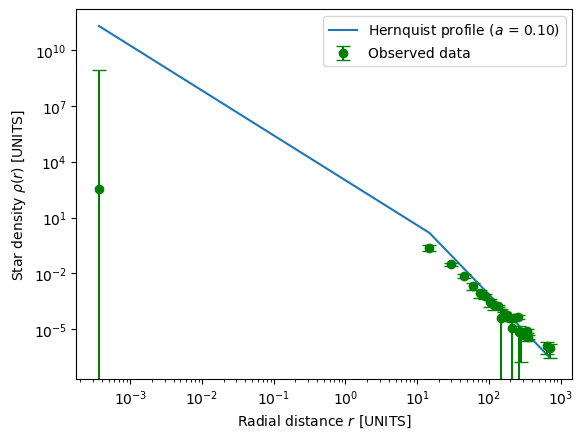

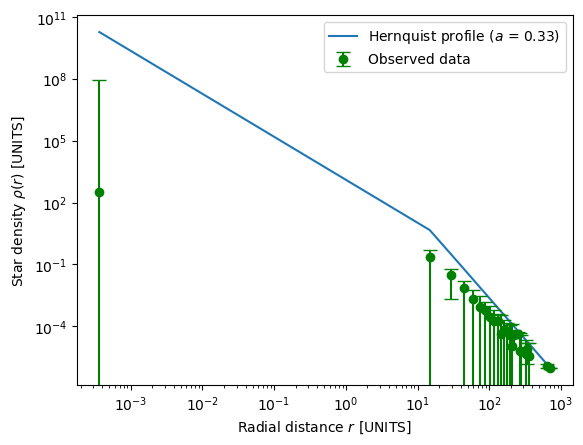

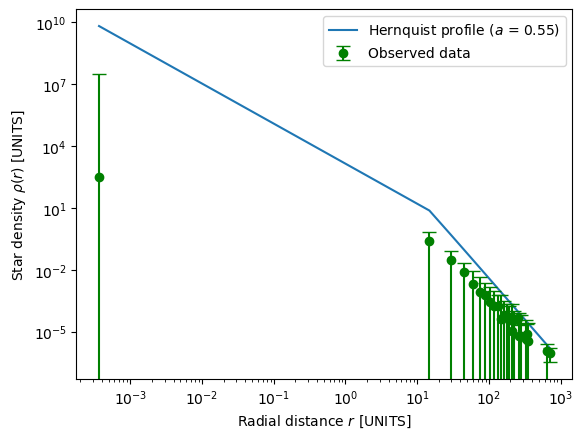

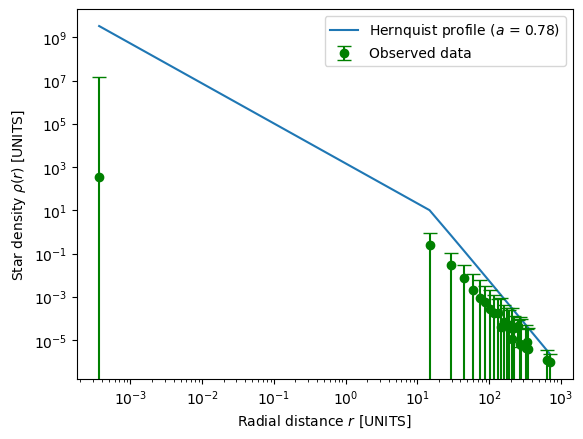

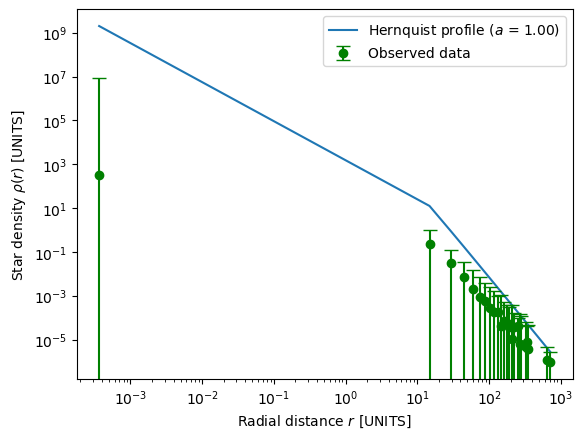

In [35]:
a = np.linspace(0.1, 1, 5)
for i in range(len(a)):
    
    rho = Hernquist_profile(shell_inner_rad, a[i])
    e_p = np.abs(rho - rho_num)/np.sqrt(N_S)
    
    fig, ax = plt.subplots()

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'Radial distance $r$ [UNITS]')
    ax.set_ylabel(r'Star density $\rho(r)$ [UNITS]')

    ax.plot(shell_inner_rad, rho, zorder=0, label=r'Hernquist profile ($a$ = {:.2f})'.format(a[i]))
    ax.errorbar(shell_inner_rad, rho_num, yerr=e_p, zorder=1, fmt='o', capsize=5, color='green', label='Observed data')

    ax.legend()
    
    
#     plt.figure()
#     plt.
#     plt.plot(shell_outer_rad, rho, label=r'Hernquist with $a$ = {:.2f}'.format{a[i]})
#     plt.errorbar(shell_outer_rad, rho_num, yerr=e_p, label='Observed')

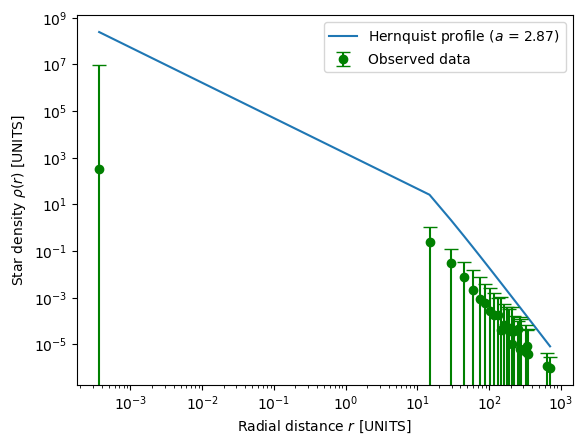

In [36]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Radial distance $r$ [UNITS]')
ax.set_ylabel(r'Star density $\rho(r)$ [UNITS]')

ax.plot(shell_inner_rad, rho_H, zorder=0, label=r'Hernquist profile ($a$ = {:.2f})'.format(a_data))
ax.errorbar(shell_inner_rad, rho_num, yerr=e_p, zorder=1, fmt='o', capsize=5, color='green', label='Observed data')

ax.legend()